In [27]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import butter,filtfilt,find_peaks,find_peaks_cwt,medfilt,savgol_filter,find_peaks
from cds_utils import butter_lowpass_filter, butter_highpass_filter, smooth, loudness_normalize,stft_with_phase
import torch
import torch.nn as nn
import pandas as pd
from test_metric_utils import *
from cds_models import MMDenseNet
# from model_AAE import FCAE
from tqdm import tqdm_notebook,tqdm
import os
import time
import IPython.display as ipd
import multiprocessing
from findpeaks.tests.libs import detect_peaks
import apex
%matplotlib inline

ModuleNotFoundError: No module named 'findpeaks'

In [ ]:
def istft(X,hop_length,n_fft):
    X = X[0] + 1j * X[1]## 2,F,T-> F,T
    return librosa.core.istft(X, hop_length=hop_length, win_length=n_fft)
def inference(model,Speech,n_fft=512,hop_length=128,n_frame = 192,window_step = 32,batch_size = 100):
    assert n_frame%window_step ==0
    
    model.eval()
    EGG_pred = np.zeros_like(Speech)
    ratio = np.zeros_like(Speech)
    frame = 0
    Speeches = []
    while frame*window_step + n_frame <= len(Speech):
        Speeches.append(Speech[frame*window_step:frame*window_step+n_frame])
        frame +=1
    
    Speeches = [stft_with_phase(loudness_normalize(speech),n_fft,hop_length,'channel')for speech in Speeches]
    
    result = None
    batch_idx = 0
    with torch.no_grad():
        while((batch_idx+1)*batch_size<=len(Speeches)):
            _Speeches = torch.Tensor(Speeches[batch_idx*batch_size:(batch_idx+1)*batch_size]).cuda()
            _result = model(_Speeches).cpu().detach().numpy() ## [B,2,F,T]
            result = _result if result is None else np.concatenate((result,_result))
            batch_idx+=1
        if batch_idx*batch_size != len(Speeches):
            _Speeches = torch.Tensor(Speeches[batch_idx*batch_size:len(Speeches)]).cuda()
            _result = model(_Speeches).cpu().detach().numpy()
            result = _result if result is None else np.concatenate((result,_result))
        
    for frame in range(len(result)):
        EGG_pred[frame*window_step:frame*window_step+n_frame] += istft(result[frame],hop_length,n_fft) ## postprocessing
        ratio[frame*window_step:frame*window_step+n_frame] +=1
#     frame +=1
    
    for i in range(len(EGG_pred)):
        if ratio[i]!=0:
            EGG_pred[i] = EGG_pred[i]/ratio[i]
            
    return EGG_pred[:n_frame + frame*window_step]

In [14]:
model = MMDenseNet(k=6,l=2)
model = nn.DataParallel(model)
model.load_state_dict(torch.load('./models/fft/exp0/best.pth'))
model.cuda()

DataParallel(
  (module): MMDenseNet(
    (lowNet): _MDenseNet_STEM(
      (first_conv): Conv2d(2, 32, kernel_size=(4, 3), stride=(1, 1))
      (downsample_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (upsample_layers): ModuleList(
        (0): ConvTranspose2d(80, 80, kernel_size=(2, 2), stride=(2, 2))
        (1): ConvTranspose2d(160, 160, kernel_size=(2, 2), stride=(2, 2))
        (2): ConvTranspose2d(228, 228, kernel_size=(2, 2), stride=(2, 2))
      )
      (dense_padding): ModuleList()
      (dense_layers): ModuleList(
        (0): _DenseBlock(
          (layers): ModuleDict(
            (denselayer1): _DenseLayer(
              (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu1): ReLU(inplace)
              (conv1): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [18]:
def get_points(EGG,DEGG):
#     EGG = normalize(EGG)
    
    CQ,avg_hl_ratio,avg_pitch = 0,0,0

#     peak_range = (7,15)
#     DEGG = np.gradient(EGG,edge_order = 2)
#     DEGG = medfilt(DEGG, 3)
    DEGG_low,EGG_low = DEGG.copy(),EGG.copy()
    
    DEGG_low[DEGG_low>0] =0
    EGG_low[EGG_low>0] =0
    
#     DEGG_low = find_peaks_cwt(-DEGG_low,np.arange(*peak_range))
    DEGG_low = detect_peaks.detect_peaks(-DEGG_low,mph=0.01, mpd=45)
#     DEGG_low = find_peaks(-DEGG_low,distance=40)
#     EGG_low = find_peaks_cwt(-EGG_low,np.arange(*peak_range))
    EGG_low = detect_peaks.detect_peaks(-EGG_low,mph=0.01, mpd=45)
#     EGG_low = find_peaks(-EGG_low,distance=40)
    
#     print(DEGG_low)
    DEGG_high = []
    for i in range(len(DEGG_low)-1):
        DEGG_high.append(DEGG_low[i] + np.argmax(DEGG[DEGG_low[i]:DEGG_low[i+1]]))

    EGG_high = []
    for i in range(len(EGG_low)-1):
        EGG_high.append(EGG_low[i] + np.argmax(EGG[EGG_low[i]:EGG_low[i+1]]))
    
    DEGG_high, EGG_high = np.array(DEGG_high),np.array(EGG_high)
    for i in range(len(DEGG_high)-1):
        CQ+=(DEGG_low[i+1]-DEGG_high[i])/((DEGG_high[i+1]-DEGG_high[i])*(len(DEGG_high)-1))
    for i in range(len(DEGG_low)-1):
        avg_hl_ratio+=(DEGG[DEGG_high[i]]/(np.abs(DEGG[DEGG_low[i]])+1e-3))/(len(DEGG_low)-1)
        avg_pitch += (16000/(DEGG_low[i+1]-DEGG_low[i]))/(len(DEGG_low)-1) ##avg period
    return DEGG_high/16000,DEGG_low/16000,EGG_high/16000,EGG_low/16000,CQ,avg_hl_ratio,avg_pitch

In [27]:
directory = './datasets/TestData/CMU/'
filelist = os.listdir(directory)
n_frame = 4096
window_step = 4096

DEGG_high_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
DEGG_low_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
EGG_high_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}
EGG_low_metrics_final = {'IDR':0, 'MR' : 0, 'FAR':0 ,'IDA':0,'ncycles':0,'nhits':0,'nmisses':0,'nfars':0}

CQ = []
hl = []
pitch = []
# filelist = filelist[100:110]
for file in tqdm(filelist[:1]):
#     print(file)
    [Speech,EGG_true],sr = librosa.load(directory + file,sr=16000,mono=False)
#     Speech = butter_lowpass_filter(Speech,2500,16000)
    itvs = librosa.effects.split(Speech,frame_length = int(512*0.75), hop_length = int(512*0.25),top_db = 15)
    EGG_pred = inference(model,Speech,n_frame = n_frame,window_step = window_step,batch_size=15000)
#     EGG_pred = np.squeeze(EGG_pred,axis=-1)
    EGG_pred = smooth(EGG_pred, 25)
    DEGG_pred = np.gradient(EGG_pred,edge_order = 2)
    DEGG_true = np.gradient(EGG_true,edge_order = 2)
#     S = []
#     E = []
#     Ep = []
#     D = []
#     Dp = []
#     for st,ed in itvs:
#         if(ed-st >=512):
#             S += list(Speech[st:ed])
#             E += list(EGG_true[st:ed])
#             Ep += list(EGG_pred[st:ed])
#             D += list(DEGG_true[st:ed])
#             Dp += list(DEGG_pred[st:ed])
#     Speech = np.array(S)
#     EGG_true = np.array(E)
#     EGG_pred = np.array(Ep)
#     DEGG_true = np.array(D)
#     DEGG_pred = np.array(Dp)
    
    l = min(len(EGG_pred),len(EGG_true))
    EGG_true =EGG_true[:l]
    EGG_pred =EGG_pred[:l]
    
#     EGG_true,EGG_pred = detect_voiced_region(EGG_true,EGG_pred)
    
    DEGG_high_true,DEGG_low_true, EGG_high_true, EGG_low_true,CQ_true,hl_true,pitch_true = get_points(EGG_true,DEGG_true)
    DEGG_high_pred,DEGG_low_pred, EGG_high_pred, EGG_low_pred,CQ_pred,hl_pred,pitch_pred = get_points(EGG_pred,DEGG_pred)
    
    CQ.append([CQ_true,CQ_pred])
    hl.append([hl_true,hl_pred])
    pitch.append([pitch_true,pitch_pred])
    
    DEGG_high_metrics = corrected_naylor_metrics(DEGG_high_true, DEGG_high_pred) ##GOI
    DEGG_low_metrics = corrected_naylor_metrics(DEGG_low_true, DEGG_low_pred) ##GCI
    EGG_high_metrics = corrected_naylor_metrics(EGG_high_true, EGG_high_pred)
    EGG_low_metrics = corrected_naylor_metrics(EGG_low_true, EGG_low_pred)

    DEGG_high_metrics_final['ncycles'] +=DEGG_high_metrics['ncycles']
    DEGG_high_metrics_final['nhits'] +=DEGG_high_metrics['nhits']
    DEGG_high_metrics_final['nmisses'] +=DEGG_high_metrics['nmisses']
    DEGG_high_metrics_final['nfars'] +=DEGG_high_metrics['nfars']
    DEGG_high_metrics_final['IDA'] += DEGG_high_metrics["identification_accuracy"]/len(filelist)

    DEGG_low_metrics_final['ncycles'] +=DEGG_low_metrics['ncycles']
    DEGG_low_metrics_final['nhits'] +=DEGG_low_metrics['nhits']
    DEGG_low_metrics_final['nmisses'] +=DEGG_low_metrics['nmisses']
    DEGG_low_metrics_final['nfars'] +=DEGG_low_metrics['nfars']
    DEGG_low_metrics_final['IDA'] += DEGG_low_metrics["identification_accuracy"]/len(filelist)

    EGG_high_metrics_final['ncycles'] +=EGG_high_metrics['ncycles']
    EGG_high_metrics_final['nhits'] +=EGG_high_metrics['nhits']
    EGG_high_metrics_final['nmisses'] +=EGG_high_metrics['nmisses']
    EGG_high_metrics_final['nfars'] +=EGG_high_metrics['nfars']
    EGG_high_metrics_final['IDA'] += EGG_high_metrics["identification_accuracy"]/len(filelist)

    EGG_low_metrics_final['ncycles'] +=EGG_low_metrics['ncycles']
    EGG_low_metrics_final['nhits'] +=EGG_low_metrics['nhits']
    EGG_low_metrics_final['nmisses'] +=EGG_low_metrics['nmisses']
    EGG_low_metrics_final['nfars'] +=EGG_low_metrics['nfars']
    EGG_low_metrics_final['IDA'] += EGG_low_metrics["identification_accuracy"]/len(filelist)

for d in [DEGG_high_metrics_final,DEGG_low_metrics_final,EGG_high_metrics_final,EGG_low_metrics_final]:
    d['IDR'] = d['nhits']/d['ncycles']
    d['MR'] = d['nmisses']/d['ncycles']
    d['FAR'] = d['nfars']/d['ncycles']

print("=========DEGG_high(GOI) detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(DEGG_high_metrics_final['IDR']*100,DEGG_high_metrics_final['MR']*100,DEGG_high_metrics_final['FAR']*100,DEGG_high_metrics_final['IDA']*1000))

print("=========DEGG_low(GCI) detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(DEGG_low_metrics_final['IDR']*100,DEGG_low_metrics_final['MR']*100,DEGG_low_metrics_final['FAR']*100,DEGG_low_metrics_final['IDA']*1000))

print("=========EGG_high detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(EGG_high_metrics_final['IDR']*100,EGG_high_metrics_final['MR']*100,EGG_high_metrics_final['FAR']*100,EGG_high_metrics_final['IDA']*1000))

print("=========EGG_low detection========")
print("IDR : %.2f MR : %.2f FAR : %.2f IDA : %.2f ms"
      %(EGG_low_metrics_final['IDR']*100,EGG_low_metrics_final['MR']*100,EGG_low_metrics_final['FAR']*100,EGG_low_metrics_final['IDA']*1000))

100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

=========DEGG_high(GOI) detection========
IDR : 83.33 MR : 0.00 FAR : 16.67 IDA : 0.00 ms
=========DEGG_low(GCI) detection========
IDR : 83.51 MR : 1.03 FAR : 15.46 IDA : 0.00 ms
=========EGG_high detection========
IDR : 66.50 MR : 25.50 FAR : 8.00 IDA : 0.00 ms
=========EGG_low detection========
IDR : 63.16 MR : 29.67 FAR : 7.18 IDA : 0.00 ms


In [31]:
plt.plot(EGG_pred[10000:12000])

NameError: name 'EGG_pred' is not defined

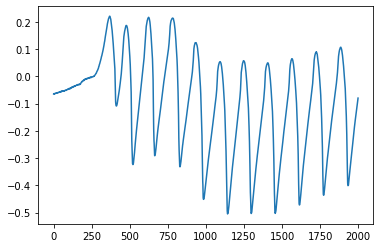

In [55]:
plt.plot(EGG_true[10000:12000])

In [2]:
from efficientunet import *
import torch
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.special import expit
%matplotlib inline

In [3]:
def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return np.log(np.maximum(x,clip_val) * C)

def stft_process(stft,mask=False):
    mag = np.abs(stft)
    phase = np.angle(stft)
    
    mag = dynamic_range_compression(mag)
#     phase = unwrap(phase)
    mag = mag[np.newaxis,:,:]
    phase = phase[np.newaxis,:,:]
    
    if mask:
        m = make_mask(mag)
        conc = np.concatenate([mag,phase,m],axis=0)
    else:
        conc = np.concatenate([mag,phase],axis=0)
    return conc

def make_mask(mag):
    mask = np.zeros_like(mag)
    m = mag.mean()
    s = mag.std()
#     print(m,s)
    mask[mag>m + 1*s] = 1
    return mask

In [7]:
model = get_efficientunet_b2(out_channels=3, concat_input=True, pretrained=False)
# model.load_state_dict(torch.load('./models/masked/exp6-re/best_5750.pth'))
model.load_state_dict(torch.load('./models/masked/exp13/best_356.pth'))
# model = torch.nn.DataParallel(model)
model.cuda()
model.eval()

EfficientUnet(
  (encoder): Encoder(
    (stem_conv): Conv2dSamePadding(
      2, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 1, 1), value=0.0)
    )
    (stem_batch_norm): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (stem_swish): Swish()
    (blocks): ModuleList(
      (0): MBConvBlock(
        (swish): Swish()
        (_depthwise_conv): Conv2dSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding)

In [8]:
[S,E] = np.load('../eggdata/TestSTFT/data/slt_arctic_b0002.npy')
# [S,E],_ = librosa.load('./vocology.WAV',sr=16000,mono=False)

In [9]:
inp = stft_process(S,mask=False)

In [10]:
tta_inp = []
tta_inp.append(inp)
for i in range(31):
    tta_inp.append(inp+0.03*np.random.normal(inp))

In [11]:
inp = torch.Tensor(inp).unsqueeze(0).cuda()
tta_inp = torch.Tensor(np.array(tta_inp)).cuda()

In [12]:
with torch.no_grad():
    out = model(inp)

In [13]:
out = out.cpu().detach().numpy()
out = np.mean(out,axis=0)[np.newaxis,:,:,:]

mag = out[0,0,:,:]
phase = out[0,1,:,:]
mask = out[0,2,:,:]

mag = np.exp(mag)
mask = np.round(expit(mask))

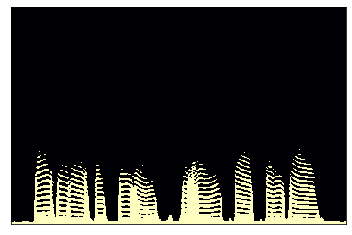

In [14]:
librosa.display.specshow(mask)

In [15]:
inp_mag = np.abs(S)
inp_phase = np.angle(S)

In [16]:
s = stft_process(E,mask=True)
mag_original = s[0,:,:]
phase_original = s[1,:,:]
mask_original = s[2,:,:]

original_signal = librosa.istft(mask_original*np.exp(mag_original)*(np.cos(phase_original)+1j*np.sin(phase_original)),hop_length=128,win_length=512)

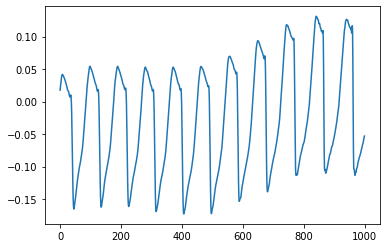

In [32]:
plt.plot(original_signal[10000:11000])

In [18]:
recon_signal = librosa.istft(mask*mag*(np.cos(phase)+1j*np.sin(phase)),hop_length=128,win_length=512)

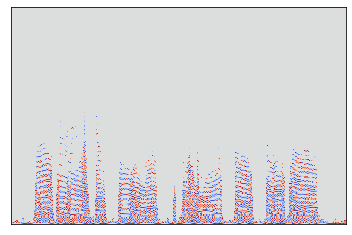

In [48]:
librosa.display.specshow(mask_original*phase_original)

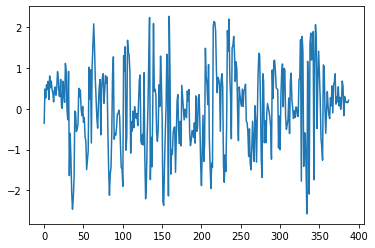

In [54]:
plt.plot(phase[100,:])

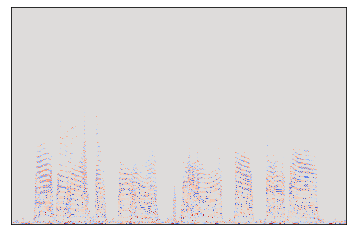

In [50]:
librosa.display.specshow(mask*phase - mask_original*phase_original)

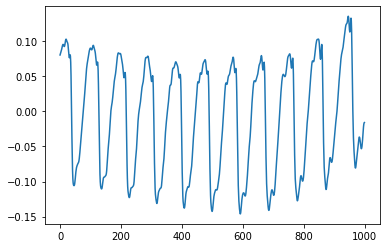

In [33]:
plt.plot(recon_signal[10000:11000])

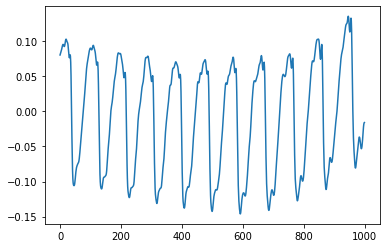

In [22]:
plt.plot(recon_signal[10000:11000])

In [23]:
get_points(original_signal,np.gradient(original_signal))

NameError: name 'detect_peaks' is not defined

In [20]:
def cosine_distance(a,b):
    cos_ = np.sum(a*b)/(np.sqrt(np.sum(a**2))*np.sqrt(np.sum(b**2)))
    plt.plot(a)
    plt.plot(b)
    return np.arccos(cos_)
#     return np.arccos(cos_)/np.pi ## angular distance

In [ ]:
st = 10000
ed = st+1500
cosine_distance(original_signal[st:ed],recon_signal[st:ed])

0.46283582